In [1]:
from typing import Union

from vivarium.core.types import State, Update

from pbg.translate import get_port_mapping
from pbg.parse import get_process, find_defaults
from process_bigraph import ProcessTypes, pp
from bigraph_schema.type_system import required_schema_keys, optional_schema_keys
from ecoli.processes.antibiotics.cell_wall import CellWall
from vivarium.core.registry import process_registry
from vivarium.core.process import Process as VivariumProcess
from ecoli.processes.registries import topology_registry
from vivarium_interface.vivarium import Vivarium
from pbg.data_model.base_process import BaseProcess, CORE
from pbg.test_output.cell_wall_edited import CellWall
from pbg.parse import find_defaults

<unknown>:1: SyntaxWarning: invalid escape sequence '\s'


In [2]:
core = ProcessTypes()

In [3]:
core.register_process('ecoli-cell-wall-edited', CellWall)

In [4]:
class Add(BaseProcess):
    defaults = {
        'k': 0.11 / 2.22
    }
    name = 'add'

    def __init__(self, parameters=None, core=None):
        super().__init__(parameters, core=core)

    def ports_schema(self):
        return {
            'A': {
                'x': {
                    '_default': -0.11,
                    '_emit': True,
                },
            },
            'B': {
                'y': {
                    '_default': 0.22,
                    '_emit': True,
                }
            }
        }

    def next_update(
            self, timestep, states):
        x0 = states['A']['x']
        x = x0 * self.parameters['k'] * timestep
        return {
            'A': {
                'x': x,
            },
            'B': {
                'y': x0 + (x * timestep)
            }
        }


core.register_process('Add', Add)

In [5]:
def make_vivarium(core=core):
    types: dict = core.types()
    processes = core.process_registry.registry
    processes.update(process_registry.registry)
    type_keys: set = required_schema_keys.union(optional_schema_keys)
    return Vivarium(types=types, processes=processes)


def get_proc(viv: Vivarium, name: str) -> BaseProcess:
    return viv.get_state()[name]['instance']

#### 1. Simple Example with Toy process

In [6]:
viv = make_vivarium()

In [7]:
viv.add_process(process_id='Add', name='add', config={'k': -11.11})

viv

Vivarium( 
{ 'add': { 'address': 'local:Add',
           'config': {'k': -11.11, 'timestep': 1.0},
           'inputs': {},
           'instance': <__main__.Add object at 0x14e202b70>,
           'interval': 1.0,
           'outputs': {}},
  'global_time': 0.0})

In [8]:
proc: BaseProcess = get_proc(viv, 'add')

proc.get_stores()

{'A': ['A'], 'B': ['B']}

In [9]:
state = find_defaults(proc.ports_schema())

viv.connect_process(
    process_name='add',
    inputs=proc.get_stores(),
    outputs=proc.get_stores()
)

viv

Vivarium( 
{ 'A': {'x': 0.0},
  'B': {'y': 0.0},
  'add': { 'address': 'local:Add',
           'config': {'k': -11.11, 'timestep': 1.0},
           'inputs': {'A': ['A'], 'B': ['B']},
           'instance': <__main__.Add object at 0x14e202b70>,
           'interval': 1.0,
           'outputs': {'A': ['A'], 'B': ['B']}},
  'global_time': 0.0})

In [10]:
viv.set_value(path=['A', 'x'], value=-11.11)
viv.set_value(path=['B', 'y'], value=22.22)

viv

Vivarium( 
{ 'A': {'x': -11.11},
  'B': {'y': 22.22},
  'add': { 'address': 'local:Add',
           'config': {'k': -11.11, 'timestep': 1.0},
           'inputs': {'A': ['A'], 'B': ['B']},
           'instance': <__main__.Add object at 0x14e202b70>,
           'interval': 1.0,
           'outputs': {'A': ['A'], 'B': ['B']}},
  'global_time': 0.0})

In [11]:
viv.add_emitter()

viv

Vivarium( 
{ 'A': {'x': -11.11},
  'B': {'y': 22.22},
  'add': { 'address': 'local:Add',
           'config': {'k': -11.11, 'timestep': 1.0},
           'inputs': {'A': ['A'], 'B': ['B']},
           'instance': <__main__.Add object at 0x14e202b70>,
           'interval': 1.0,
           'outputs': {'A': ['A'], 'B': ['B']}},
  'emitter': { 'address': 'local:ram-emitter',
               'config': { 'emit': { 'A': 'any',
                                     'B': 'any',
                                     'global_time': 'any'}},
               'inputs': { 'A': ['A'],
                           'B': ['B'],
                           'global_time': ['global_time']},
               'instance': <process_bigraph.composite.RAMEmitter object at 0x14038db80>,
               'outputs': None},
  'global_time': 0.0})

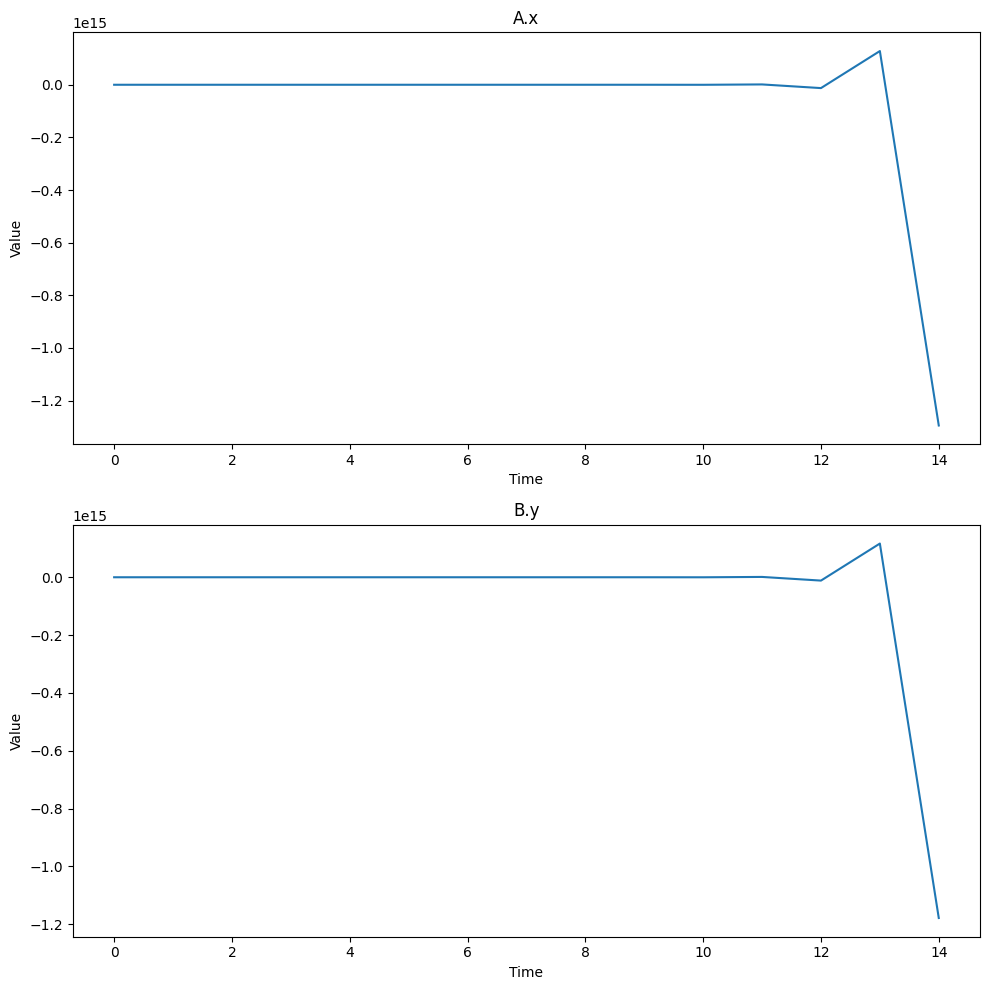

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

viv.run(14)
ts = viv.get_timeseries()
viv.plot_timeseries()

#### 2. Example using an existing ecoli process which has been converted with the cli app

In [13]:
viv2 = make_vivarium()

In [14]:
wall_id = 'ecoli-cell-wall-edited'
viv2.add_process(
    process_id=wall_id,
    name='wall-0',
)

In [15]:
wall = get_proc(viv2, 'wall-0')

In [16]:
ports = wall.get_stores()

In [17]:
wall.initial_state()

{'murein_state': {'incorporated_murein': 0,
  'unincorporated_murein': 0,
  'shadow_murein': 0},
 'bulk': [],
 'shape': {'volume': 0},
 'wall_state': {'lattice': None,
  'lattice_rows': 0,
  'lattice_cols': 0,
  'extension_factor': 1,
  'cracked': False,
  'attempted_shrinkage': False},
 'pbp_state': {'active_fraction_PBP1A': 0.0, 'active_fraction_PBP1B': 0.0},
 'listeners': {'porosity': 0,
  'hole_size_distribution': array([], dtype=int64),
  'strand_length_distribution': []}}

In [18]:
ports

{'murein_state': ['murein_state'],
 'shape': ['shape'],
 'wall_state': ['wall_state'],
 'pbp_state': ['pbp_state'],
 'listeners': ['listeners']}

In [19]:
viv2.connect_process(
    process_name='wall-0',
    inputs=ports,
    outputs=ports
)

TypeError: string indices must be integers, not 'str'

In [17]:
viv2

TypeError: string indices must be integers, not 'str'